# Machine Learning

## Notebook #2: Model 1
*This is the 2nd notebook of 3 notebooks for the WiDS Datathon 2024 Challenge #1 Kaggle challenge that ran from 1/9/2024 to 3/1/2024 Main challenge page link: https://www.kaggle.com/competitions/widsdatathon2024-challenge1/overview . Below is my process and breakdown of 3 ML models including training, fitting, testing, cross-validating, selecting the best predictive model, fine-tuning it, evaluating metrics and model performance, and finally producing a submission file.*

*Between Notebook #2 and Notebook #3, Notebook #3 would be my go to for a benchmark baseline model.*

### Train ML Algorithm

In [1]:
# import libraries and packages. Load train and test datasets
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
#import optuna
from sklearn.linear_model import SGDClassifier
from IPython.display import HTML, display
import tabulate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# Training set
pdf = pd.read_csv('pandas-train.csv')
sdf = pd.read_csv('scikitlearn-train.csv')

# Test set
ptdf = pd.read_csv('pandas-test.csv')
stdf = pd.read_csv('scikitlearn-test.csv')

# Submission set
submission = pd.read_csv('sample_submission.csv')

#### Training, Test Splits, and Scaling

*I wanted to test the difference between Pandas and Sci-kit Learn's one-hot encoding methods to see if there would be any difference in training and testing different ML models. Since the original test data has no DiagPeriodL90D target column, there are no truth labels to benchmark our models off of and therefore no y_test*

*Note: After rigorous training and testing, it seems the preprocessing stage needs to be revisited. My final model may have been overfitted*

In [2]:
X = sdf.drop(['DiagPeriodL90D', 'patient_id'], axis=1)
y = sdf['DiagPeriodL90D']

In [3]:
X.shape

(12906, 295)

In [4]:
# Train, test split, data. Note this is only a portion of the data I preprocessed.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [5]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
x_test2.shape, x_train2.shape, y_train2.shape

((5792, 277), (12906, 296), (12906,))

*Dimensions are off. Training and testing data were not properly preprocessed for training and testing it appears.*

### Evaluation Performance and Metrics

#### ROC Curves and AUC

In [6]:
def compare_classifiers(classifiers, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(8, 6))

    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        if hasattr(clf, "decision_function"):
            y_test_scores = clf.decision_function(X_test)
        else:
            y_test_scores = clf.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_test_scores)
        auc_score = roc_auc_score(y_test, y_test_scores)
        plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

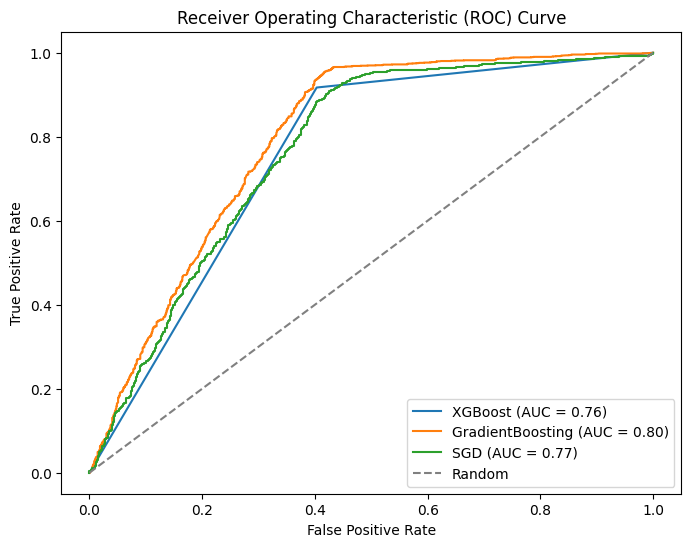

In [7]:
# Define model classifiers
classifiers = {
    'XGBoost': XGBClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'SGD': SGDClassifier()
}

# Perform model comparisons
#compare_classifiers(classifiers, x_train, y_train)
compare_classifiers(classifiers, X_train, y_train, X_test, y_test)

#### Cross-validation Accuracy

*The best cross-validation accuracy looks to be with scikit-learn's one-hot encoding methods with the GradientBoostingClassifier*

In [8]:
# Define model classifiers
classifiers = {
    'XGBoost': XGBClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'SGD': SGDClassifier()
}

print('Scikit-Learn training data:')
for clf_name, clf in classifiers.items():
    scores2 = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{clf_name} model cross-validation accuracy: {scores2.mean():.4f} (+/- {scores2.std() * 2:.2f})")

Scikit-Learn training set:
XGBoost model cross-validation accuracy: 0.7859 (+/- 0.01)
GradientBoosting model cross-validation accuracy: 0.8085 (+/- 0.00)
SGD model cross-validation accuracy: 0.7608 (+/- 0.02)


### Plot Learning Curves

*I left this function here for plotting the learning curve in case you want to use it for checking the data or building your own model.*

In [17]:
def plot_learning_curve(model, x_train, y_train, cv=5, scoring='accuracy'):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, x_train, y_train, cv=cv, n_jobs=-1, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title('Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel(scoring.capitalize())
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [ ]:
# Initialize the models
gb_model = GradientBoostingClassifier()
xgb_model = XGBClassifier()
sgd_model = SGDClassifier()

# Plot learning curves for each model
print('Gradient Boosting Model')
plot_learning_curve(gb_model, x_train, y_train)
print('XGBoost Model')
plot_learning_curve(xgb_model, x_train, y_train)
print('Stochastic Gradient Descent Model')
plot_learning_curve(sgd_model, x_train, y_train)

#### Hyper-parameter Tuning
*I'm selecting the sci-kit learn training and test set to train the Gradient Boosting model. From here I will fine tune the model and look for the best parameters.*

#### GridSearchCV

*Note: Fine-tuning the Gradient Boosting model was taking over 3 hours on my machine. Try 1 or 2 parameters first at a time.*

In [9]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1],
    #'subsample': [0.5, 0.7, 1.0],
    #'min_samples_split': [2, 4, 6],
    #'min_samples_leaf': [1, 2, 3],
    #'max_depth': [3, 5, 7],
    #'max_features': ['sqrt', 'log2', None]
    # you can add more parameters here or shorten the list.
}

clf = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

#grid_search.fit(x_train2, y_train2)

#best_clf = grid_search.best_estimator_

In [ ]:
# Perform cross-validation
scores3 = cross_val_score(best_clf, x_train2, y_train2, cv=5)

# Mean accuracy scores
print("Accuracy: %0.4f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

print()

# Box plot of scores
plt.boxplot(scores3)
plt.title('Gradient Boosting Model Cross-validation Scores')
plt.show()

In [21]:
print(grid_search.best_params_)

{'learning_rate': 0.1, 'n_estimators': 100}


In [22]:
print(grid_search.best_score_)

0.8100880203333002


#### Best Parameters and Prediction

In [11]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [12]:
# Finding the best parameters from fine-tuning
best_params = grid_search.best_params_

# Initialize a new instance of the model with the best parameters
best_model = GradientBoostingClassifier(**best_params)

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test data
#y_test_pred = best_model.predict(x_test2)

GradientBoostingClassifier()

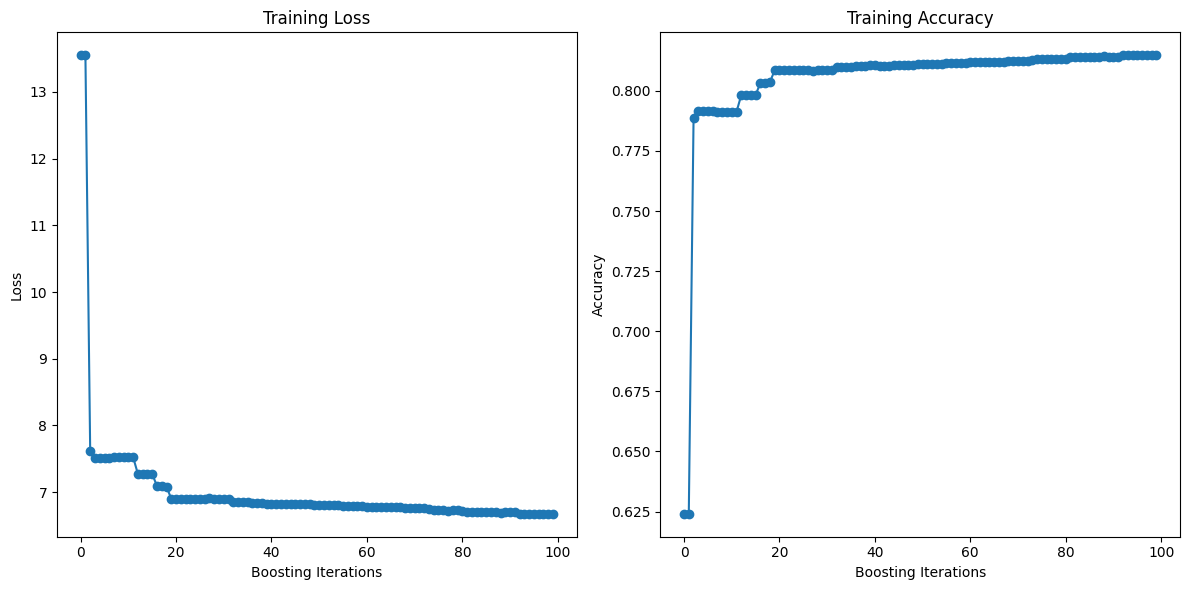

In [16]:
from sklearn.metrics import log_loss

# Initialize lists to store the loss and accuracy at each stage
train_loss = []
train_acc = []

# For each stage of the training
for y_pred in best_model.staged_predict(X_train):
    # Calculate the loss and accuracy
    loss = log_loss(y_train, y_pred)
    acc = accuracy_score(y_train, y_pred)

    # Add the loss and accuracy to the lists
    train_loss.append(loss)
    train_acc.append(acc)

# Plot the training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'o-')
plt.title('Training Loss')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')

# Plot the training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'o-')
plt.title('Training Accuracy')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

#### Feature Importance

*'Feature 36' looks important. I narrowed it down to 3-4 columns below. Socioeconomic status or income seems to be a predictive feature. See below.*

*Note: This was from my original run looking to benchmark my model.*

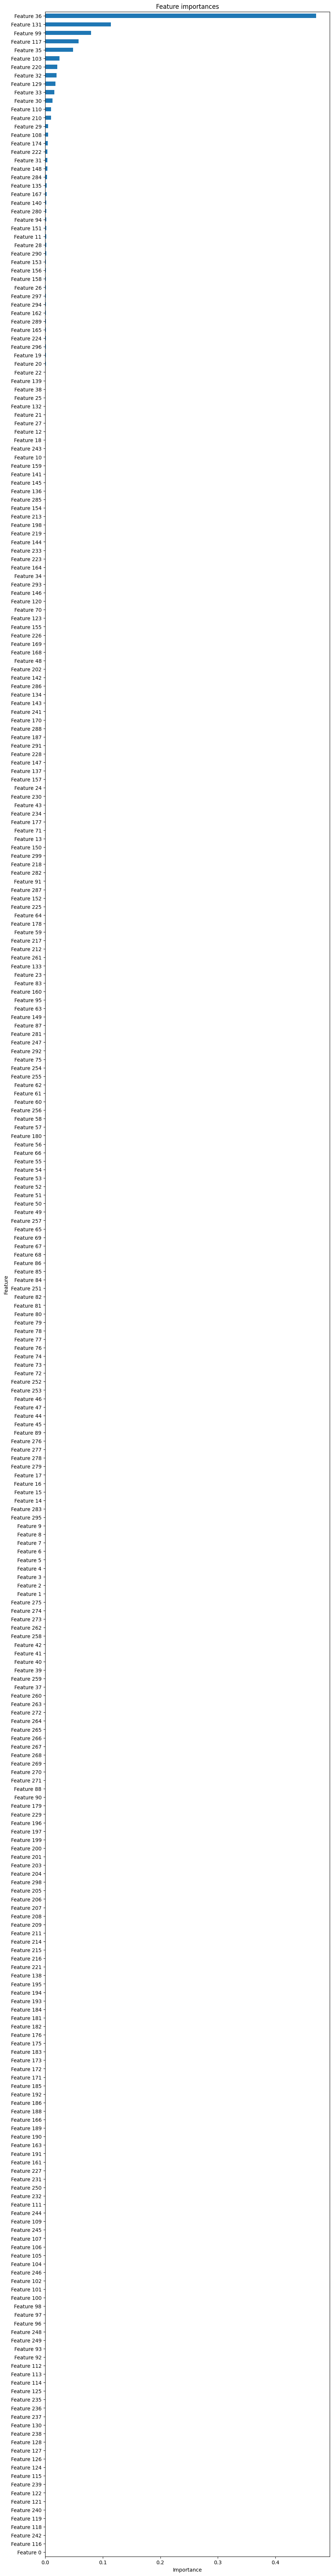

In [24]:
# Get feature names
feature_names = ["Feature " + str(i) for i in range(x_train2.shape[1])]

# Create a pandas Series with feature importances
importances = pd.Series(best_model.feature_importances_, index=feature_names)

# Sort the importances
sorted_importances = importances.sort_values()

# Create a horizontal bar plot
plt.figure(figsize=(10, 0.3 * len(feature_names)))
sorted_importances.plot(kind='barh')
plt.title('Feature importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

*I narrowed down most important features down to income. Maybe socioeconomic status (SES) is another feature besides air quality (NO2) that is an important subject to look into. Also 'Feature 99' looks to be worth looking into.*

In [25]:
# Feature 36 is between these columns
f = sdf.iloc[:, 35:39]
f

,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership
0,7.528571,19.100000,24563.57143,44.585714
1,29.596970,49.357576,41287.27273,61.463636
2,18.680000,39.555000,40399.03333,72.745000
3,38.057143,56.907143,55336.28571,59.221429
4,8.606000,22.226000,29073.18367,77.098000
...,...,...,...,...
12901,7.358824,18.352941,27888.52941,55.905882
12902,37.245000,55.248750,52778.65000,67.480000
12903,38.057143,56.907143,55336.28571,59.221429
12904,21.318421,36.207895,39491.78947,29.931579


#### Evaluation Metrics

*Since there is no y_test, I tried to evaluate metrics with y_train2. You need y_test which the testing data does not have since we are making metastatic cancer diagnosis predictions. So there is no y_test benchmark with which we can efficiently benchmark test our final model for model accuracy against our y_test_pred predictions.*

In [ ]:
# Calculate Accuracy, Precision, Recall, and F1 Score for the training set
accuracy = accuracy_score(y_train2, y_test_pred) # suppose to be y_test not y_train2
precision = precision_score(y_train2, y_test_pred)
recall = recall_score(y_train2, y_test_pred)
f1 = f1_score(y_train2, y_test_pred)

df_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})

# Display table of eval metrics
display(HTML(tabulate.tabulate(df_metrics, tablefmt='html', headers='keys')))

#### Optuna

*I came across this hyperparameter optimization framework called Optuna. Based on a brief search, it was released about 2020. Optuna supports Python 3.7 or newer so I was unable to fine-tune with it. See documentation.*

*Optuna Documentation: https://optuna.readthedocs.io/en/stable/installation.html*

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 1.0, 0.1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 6)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    clf = GradientBoostingClassifier(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        subsample=subsample, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, 
        max_depth=max_depth, 
        max_features=max_features, 
        random_state=42
    )

    return cross_val_score(clf, x_train2, y_train2, cv=5, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

### Apply ML to the challenge test set

*Submission file of cancer diagnosis predictions*

In [20]:
# Add 19 new features with 0 and 1 values
for i in range(19):
    stdf[f'new_feature_{i}'] = np.random.choice([0, 1], size=len(stdf))

In [21]:
# Save the 'submission' DataFrame to a CSV file
test = stdf.drop('patient_id', axis=1)
predictions = best_model.predict(test)
submission["DiagPeriodL90D"] = predictions
submission.to_csv('submission.csv',index=False)

/home/rcwsl/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [22]:
submission.head()

,patient_id,DiagPeriodL90D
0,573710,1
1,593679,1
2,184532,0
3,447383,0
4,687972,1


In [23]:
submission

,patient_id,DiagPeriodL90D
0,573710,1
1,593679,1
2,184532,0
3,447383,0
4,687972,1
...,...,...
5787,977076,1
5788,922960,1
5789,759690,0
5790,911717,1


In [29]:
sub = submission['DiagPeriodL90D'].value_counts()
print(sub)

DiagPeriodL90D
1    3718
0    2074
Name: count, dtype: int64


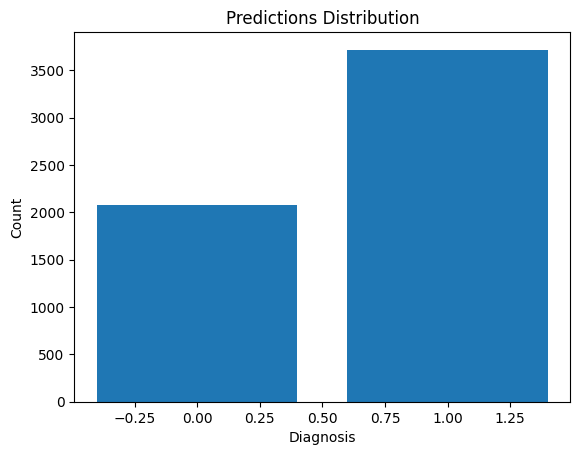

In [31]:
plt.bar(sub.index, sub.values)
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Predictions Distribution')
# plt.savefig('target-variable.png', dpi=300) # Save Image
plt.show()